<a href="https://colab.research.google.com/github/medha-sagar/CSE547-BigDataForMachineLearning/blob/master/CSE547_HW2_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSE547 - K-Means

Adapted from Stanford's CS246

### Setup

Let's setup Spark on your Colab environment.  Run the cell below!

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 217.8MB 62kB/s 
     |████████████████████████████████| 204kB 37.8MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=f3dfaac8e91c121eccd90e79eccb0d2f2851b995cdab2ff3b4a0dcc2df8f5d52
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark
openjdk-8-jdk-headless is already the newest version (8u242-b08-0ubuntu3~18.04).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


Now we authenticate a Google Drive client to download the file we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
id='1xvgbI1D81hk8-oVXtzd_G0s16SPSuviX'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('data')

id='17WSIDeXYS0upE0cqsa6I9osPJz4r6RQB'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('c1')

id='1dhGb4aIsOO645AQ9zVagR4oWyblqJ63I'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('c2')

If you executed the cells above, you should be able to see the dataset we will use for this Colab under the "Files" tab on the left panel.

Next, we import some of the common libraries needed for our task.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

Let's initialize the Spark context.

In [0]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

sqlContext = SQLContext(sc)

In [0]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)


You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [7]:
spark

If you are running this Colab on the Google hosted runtime, the cell below will create a *ngrok* tunnel which will allow you to still check the Spark UI.

In [8]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-04-26 19:17:43--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.232.135.84, 3.228.72.85, 34.197.27.35, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.232.135.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  19.1MB/s    in 0.7s    

2020-04-26 19:17:44 (19.1 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


### Data Loading

In [0]:
data = spark.read.option("sep", " ").csv("data", header=False)
c1 = spark.read.option("sep", " ").csv("c1", header=False)
c2 = spark.read.option("sep", " ").csv("c2", header=False)

In [0]:
data.show()

+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+----+-----+-----+-----+------+----+----+----+
| _c0| _c1| _c2|_c3| _c4| _c5| _c6| _c7| _c8| _c9|_c10|_c11|_c12|_c13|_c14|_c15|_c16|_c17|_c18|_c19|_c20|_c21|_c22|_c23|_c24|_c25|_c26|_c27|_c28|_c29|_c30|_c31|_c32|_c33|_c34|_c35|_c36|_c37|_c38|_c39|_c40|_c41|_c42|_c43|_c44|_c45|_c46|_c47| _c48| _c49|_c50| _c51| _c52| _c53|  _c54|_c55|_c56|_c57|
+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+----+-----+-----+-----+------+----+----+----+
|   0|0.64|0.64|  0|0.32|   0|   0|   0|   0|   0|   0|0.64|   0|   0|   0|0.32|   0|1.29|1.93|   0|0.96| 

In [0]:
c1.show()

+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+-----+-----+-----+-----+----+----+----+
| _c0| _c1| _c2|_c3| _c4| _c5| _c6| _c7| _c8| _c9|_c10|_c11|_c12|_c13|_c14|_c15|_c16|_c17|_c18|_c19|_c20|_c21|_c22|_c23|_c24|_c25|_c26|_c27|_c28|_c29|_c30|_c31|_c32|_c33|_c34|_c35|_c36|_c37|_c38|_c39|_c40|_c41|_c42|_c43|_c44|_c45|_c46|_c47|_c48| _c49|_c50| _c51| _c52| _c53| _c54|_c55|_c56|_c57|
+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+-----+-----+-----+-----+----+----+----+
|   0|0.64|0.64|  0|0.32|   0|   0|   0|   0|   0|   0|0.64|   0|   0|   0|0.32|   0|1.29|1.93|   0|0.96|   0|  

In [0]:
c2.show()

+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-------+----+-----+----+
| _c0| _c1| _c2| _c3| _c4| _c5| _c6| _c7| _c8| _c9|_c10|_c11|_c12|_c13|_c14|_c15|_c16|_c17|_c18|_c19|_c20|_c21|_c22|_c23|_c24|_c25|_c26|_c27|_c28|_c29|_c30|_c31|_c32|_c33|_c34|_c35|_c36|_c37|_c38|_c39|_c40|_c41|_c42|_c43|_c44|_c45|_c46|_c47| _c48| _c49| _c50| _c51| _c52| _c53|   _c54|_c55| _c56|_c57|
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-------+----+-----+----+
|   0|0.64|0.64|   0|0.32|   0|   0|   0|   0|   0|   0|0.64|   0|   0|   0|0.32|   0|1.29|1.9

In [0]:
import numpy as np

In [0]:
def euclidean_cost(cluster_map):
  rmse = []
  iterr = 0
  document_map = data
  doc_cluster = []
  for document in document_map.rdd.collect():
    lowest_dist = 1000000000000000000
    document = [float(d) for d in document]
    for cluster in cluster_map.rdd.collect():
      cluster = [float(c) for c in cluster]
      
      diff = np.asarray(document)- np.asarray(cluster)
      cur_dist = np.linalg.norm(diff)
      if (cur_dist < lowest_dist):
        lowest_dist = cur_dist
        closest_cluster = cluster
    doc_cluster.append([tuple(document),  tuple(closest_cluster)])
    rmse.append(np.sum((np.asarray(document) - np.asarray(closest_cluster))**2))
    iterr += 1

  return (rmse, doc_cluster)

In [30]:
cluster_map = c1
costs = []
for partition in range(21):
  print("Partition : ", partition)
  rmse, doc_cluster = euclidean_cost(cluster_map)
  print(len(rmse))
  print(len(doc_cluster))
  cost = np.sum(np.asarray(rmse))
  print("Cost : ", cost)
  costs.append(cost)
  doc_sum = 0
  new_clusters = []
  for cluster in cluster_map.rdd.collect():
    cluster = [float(c) for c in cluster]
    doc_list = []
    for i in range(len(doc_cluster)):
      if doc_cluster[i][1] == tuple(cluster):
        doc_list.append(doc_cluster[i][0])
    doc_sum += len(doc_list)
    df = pd.DataFrame.from_records(doc_list)
    new_clusters.append(df.mean())
  print(doc_sum)
  c3 = pd.DataFrame.from_records(new_clusters)
  cluster_map = sqlContext.createDataFrame(c3)


Partition :  0
4601
4601
Cost :  623660345.306411
4601
Partition :  1
4601
4601
Cost :  509862908.2975452
4601
Partition :  2
4601
4601
Cost :  485480681.8720081
4601
Partition :  3
4601
4601
Cost :  463997011.6850127
4601
Partition :  4
4601
4601
Cost :  460969266.5729965
4601
Partition :  5
4601
4601
Cost :  460537847.98276794
4601
Partition :  6
4601
4601
Cost :  460313099.65354526
4601
Partition :  7
4601
4601
Cost :  460003523.88940734
4601
Partition :  8
4601
4601
Cost :  459570539.3177351
4601
Partition :  9
4601
4601
Cost :  459021103.342291
4601
Partition :  10
4601
4601
Cost :  458490656.19198096
4601
Partition :  11
4601
4601
Cost :  457944232.58797425
4601
Partition :  12
4601
4601
Cost :  457558005.1986768
4601
Partition :  13
4601
4601
Cost :  457290136.35230196
4601
Partition :  14
4601
4601
Cost :  457050555.0595628
4601
Partition :  15
4601
4601
Cost :  456892235.61535484
4601
Partition :  16
4601
4601
Cost :  456703630.7370337
4601
Partition :  17
4601
4601
Cost :  45

In [31]:
print(costs)

[623660345.306411, 509862908.2975452, 485480681.8720081, 463997011.6850127, 460969266.5729965, 460537847.98276794, 460313099.65354526, 460003523.88940734, 459570539.3177351, 459021103.342291, 458490656.19198096, 457944232.58797425, 457558005.1986768, 457290136.35230196, 457050555.0595628, 456892235.61535484, 456703630.7370337, 456404203.0189748, 456177800.5419932, 455986871.02734584, 455729268.3551454]


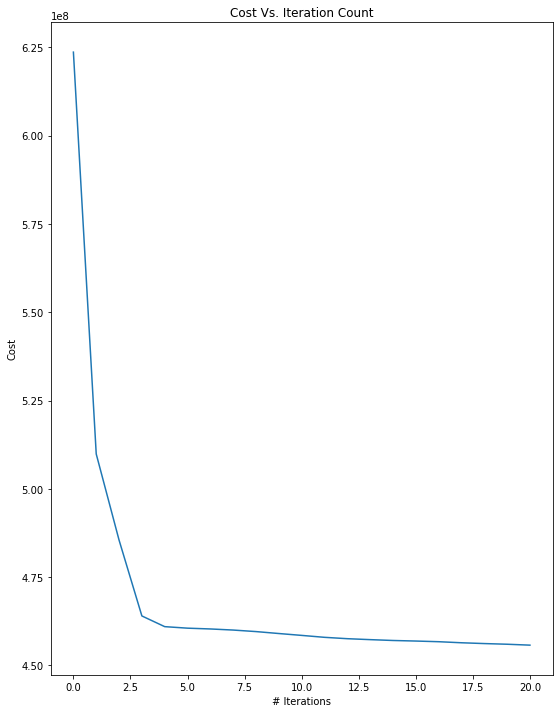

In [44]:
plt.figure(figsize=(9,12))
plt.plot(costs)
plt.title("Cost Vs. Iteration Count")
plt.xlabel("# Iterations")
plt.ylabel("Cost")
plt.savefig('fig1.png', dpi = 300)
plt.show()

[623660345.306411, 509862908.2975452, 485480681.8720081, 463997011.6850127, 460969266.5729965, 460537847.98276794, 460313099.65354526, 460003523.88940734, 459570539.3177351, 459021103.342291, 458490656.19198096, 457944232.58797425, 457558005.1986768, 457290136.35230196, 457050555.0595628, 456892235.61535484, 456703630.7370337, 456404203.0189748, 456177800.5419932, 455986871.02734584, 455729268.3551454]

In [33]:
cluster_map = c2
c2_costs = []
for partition in range(21):
  print("Partition : ", partition)
  rmse, doc_cluster = euclidean_cost(cluster_map)
  cost = np.sum(np.asarray(rmse))
  print("Cost : ", cost)
  c2_costs.append(cost)
  doc_sum = 0
  new_clusters = []
  for cluster in cluster_map.rdd.collect():
    cluster = [float(c) for c in cluster]
    doc_list = []
    for i in range(len(doc_cluster)):
      if doc_cluster[i][1] == tuple(cluster):
        doc_list.append(doc_cluster[i][0])
    doc_sum += len(doc_list)
    df = pd.DataFrame.from_records(doc_list)
    new_clusters.append(df.mean())
  print(doc_sum)
  c3 = pd.DataFrame.from_records(new_clusters)
  cluster_map = sqlContext.createDataFrame(c3)

Partition :  0
Cost :  438747790.02791697
4601
Partition :  1
Cost :  249803933.62600315
4601
Partition :  2
Cost :  194494814.40631247
4601
Partition :  3
Cost :  169804841.45154297
4601
Partition :  4
Cost :  156295748.80627602
4601
Partition :  5
Cost :  149094208.1089661
4601
Partition :  6
Cost :  142508531.61961526
4601
Partition :  7
Cost :  132303869.40652972
4601
Partition :  8
Cost :  117170969.83719075
4601
Partition :  9
Cost :  108547377.17857005
4601
Partition :  10
Cost :  102237203.317996
4601
Partition :  11
Cost :  98278015.74975672
4601
Partition :  12
Cost :  95630226.12177396
4601
Partition :  13
Cost :  93793314.05119297
4601
Partition :  14
Cost :  92377131.96821076
4601
Partition :  15
Cost :  91541606.25423887
4601
Partition :  16
Cost :  91045573.83042458
4601
Partition :  17
Cost :  90752240.101408
4601
Partition :  18
Cost :  90470170.18122733
4601
Partition :  19
Cost :  90216416.17563124
4601
Partition :  20
Cost :  90162390.9104141
4601


In [34]:
print(c2_costs)

[438747790.02791697, 249803933.62600315, 194494814.40631247, 169804841.45154297, 156295748.80627602, 149094208.1089661, 142508531.61961526, 132303869.40652972, 117170969.83719075, 108547377.17857005, 102237203.317996, 98278015.74975672, 95630226.12177396, 93793314.05119297, 92377131.96821076, 91541606.25423887, 91045573.83042458, 90752240.101408, 90470170.18122733, 90216416.17563124, 90162390.9104141]


In [0]:
#[438747790.02791697, 249803933.62600315, 194494814.40631247, 169804841.45154297, 156295748.80627602, 149094208.1089661, 142508531.61961526, 132303869.40652972, 117170969.83719075, 108547377.17857005, 102237203.317996, 98278015.74975672, 95630226.12177396, 93793314.05119297, 92377131.96821076, 91541606.25423887, 91045573.83042458, 90752240.101408, 90470170.18122733, 90216416.17563124, 90162390.9104141]

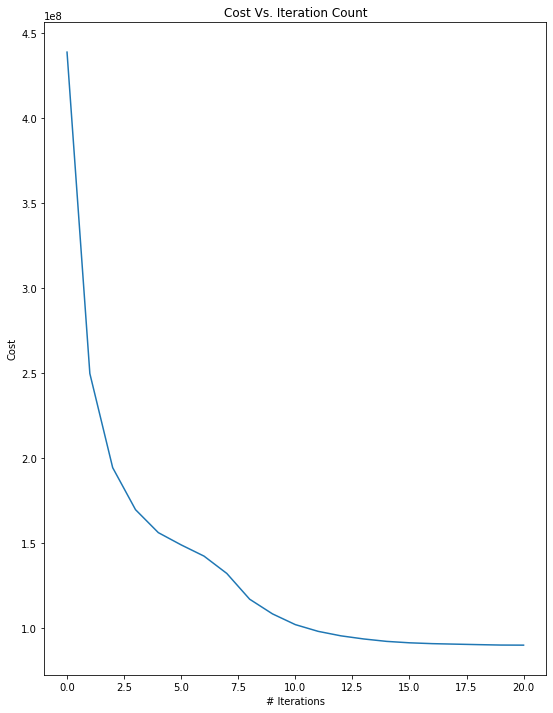

In [47]:
plt.figure(figsize=(9,12))
plt.plot(c2_costs)
plt.title("Cost Vs. Iteration Count")
plt.xlabel("# Iterations")
plt.ylabel("Cost")
plt.savefig('fig2.png', dpi = 300)
plt.show()

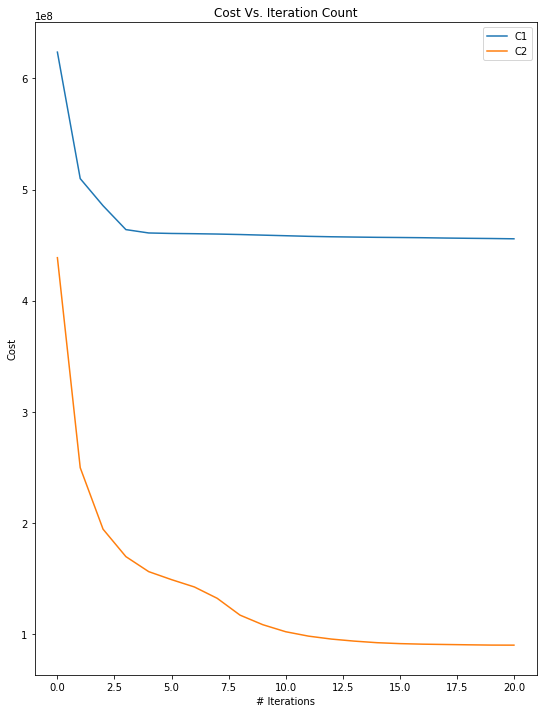

In [48]:
plt.figure(figsize=(9,12))
plt.plot(costs)
plt.plot(c2_costs)
plt.title("Cost Vs. Iteration Count")
plt.xlabel("# Iterations")
plt.ylabel("Cost")
plt.legend(['C1', 'C2'])
plt.savefig('fig3.png', dpi = 300)
plt.show()

Partition :  0
Cost :  438747790.02791697
Partition :  1
Cost :  251125286.23381487
Partition :  2
Cost :  193710134.90986466
Partition :  3
Cost :  168519003.53136647
Partition :  4
Cost :  154689448.10528445
Partition :  5
Cost :  146592436.46744326
Partition :  6

In [0]:
def manhattan_cost(cluster_map):
  rmse = []
  iterr = 0
  document_map = data
  doc_cluster = []
  for document in document_map.rdd.collect():
    lowest_dist = 1000000000000000000
    document = [float(d) for d in document]
    for cluster in cluster_map.rdd.collect():
      cluster = [float(c) for c in cluster]
      
      diff = np.asarray(document)- np.asarray(cluster)
      cur_dist = np.linalg.norm(diff)
      if (cur_dist < lowest_dist):
        lowest_dist = cur_dist
        closest_cluster = cluster
    doc_cluster.append([tuple(document),  tuple(closest_cluster)])
    rmse.append(np.sum(np.abs(np.asarray(document) - np.asarray(closest_cluster))))
    iterr += 1

  return (rmse, doc_cluster)

In [28]:
cluster_map = c1
costs = []
for partition in range(6):
  print("Partition : ", partition)
  rmse, doc_cluster = manhattan_cost(cluster_map)
  print(len(rmse))
  print(len(doc_cluster))
  cost = np.sum(np.asarray(rmse))
  print("Cost : ", cost)
  costs.append(cost)
  doc_sum = 0
  new_clusters = []
  for cluster in cluster_map.rdd.collect():
    cluster = [float(c) for c in cluster]
    doc_list = []
    for i in range(len(doc_cluster)):
      if doc_cluster[i][1] == tuple(cluster):
        doc_list.append(doc_cluster[i][0])
    doc_sum += len(doc_list)
    df = pd.DataFrame.from_records(doc_list)
    new_clusters.append(df.median())
  print(doc_sum)
  c3 = pd.DataFrame.from_records(new_clusters)
  cluster_map = sqlContext.createDataFrame(c3)

Partition :  0
4601
4601
Cost :  554359.395
4601
Partition :  1
4601
4601
Cost :  432020.1645
4601
Partition :  2
4601
4601
Cost :  422001.4280000001
4601
Partition :  3
4601
4601
Cost :  418448.07600000006
4601
Partition :  4
4601
4601
Cost :  416790.845
4601
Partition :  5
4601
4601
Cost :  415676.1165
4601


565788.0584027767